# GAN
___


In this notebook we'll create GAN model to generate images with cats.

Based on the [TDS post](https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5)

## Plan

1. Load data
2. Preprocess data
3. Create two models - Generator and Discriminator
4. Organize loss calculation
5. Generate cats!
6. Repeat for human faces!

## Import libraries

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [ ]:
!wget https://www.dropbox.com/s/329oy3cprlvn5vb/archive.zip

--2021-04-14 15:56:18--  https://www.dropbox.com/s/329oy3cprlvn5vb/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/329oy3cprlvn5vb/archive.zip [following]
--2021-04-14 15:56:19--  https://www.dropbox.com/s/raw/329oy3cprlvn5vb/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce3669a2d308e57003370d29ddb.dl.dropboxusercontent.com/cd/0/inline/BMkAEpxdK4cB3COTMkRt6JhIGKQx6aDwEGI0u7Ju31b6IaF3itsOMDICszTULNuJrfKmo7M1forXWU2lCjquSmMWCPPnh1Ua9R3HC8Te9gciKho3VKbU_hh3mrmFDr3enTZ3H6ghx1FPBH0yxZDSVp9S/file# [following]
--2021-04-14 15:56:19--  https://uce3669a2d308e57003370d29ddb.dl.dropboxusercontent.com/cd/0/inline/BMkAEpxdK4cB3COTMkRt6JhIGKQx6aDwEGI0u7Ju31b6IaF3itsOMDICszTULNuJrfKmo7M1forXWU2lCjquSmMWCPPnh

In [ ]:
from zipfile import ZipFile

with ZipFile('archive.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
DATA_DIR = './cats/'

## Preprocess data

Before training the model images have to be preprocessed:

1. The colors should be normalized (all RGB layers)
2. Images have to be sampled as batches

In [ ]:
# set parameters of the transformed data
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# As dataset is stored in the directory, we can create dataset
# as ImageFolder PyTorch object and set all the transformations here
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
# Create PyTorch DataLoader object to produce batches
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Visualization functions

In [ ]:
# for the nicer images visualization 
# we make inverse transformation for normalization
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
# functions to plot images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

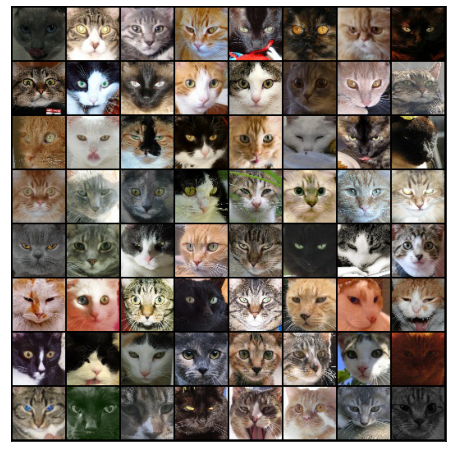

In [ ]:
show_batch(train_dl)

## Create models

**Discriminator** - model to classify images as real and generated. 

*Note*: Start simple. A few convolutions & batch normalization would do, inception/resnet is an overkill. Too smart discriminator hardly can be fooled by a generator, so the training can be overcomplicated.

**Generator** - decoder producing images from the vector of normal distribution.

*Note*: use ConvTranspose layers as inversion of usual convolutions.






In [ ]:
# Utils functions for GPU usage of neural networks
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


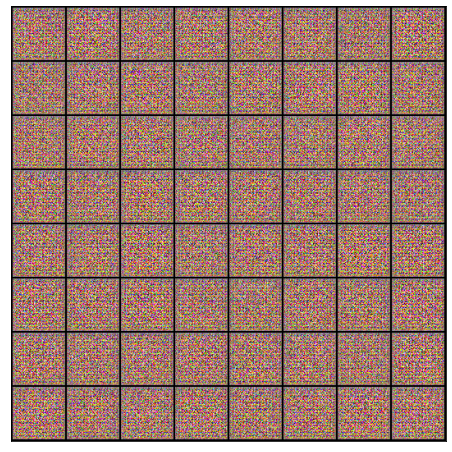

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


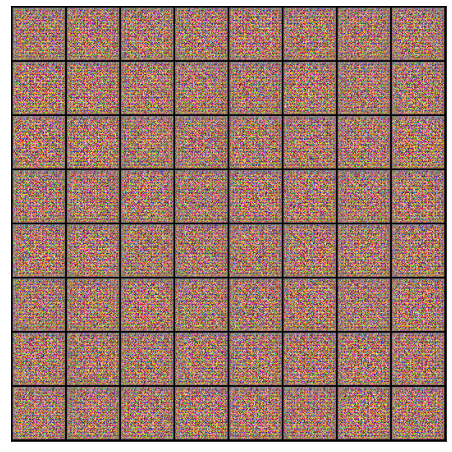

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=True)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 60

In [ ]:
history = fit(epochs, lr)


Epoch [1/60], loss_g: 2.4429, loss_d: 1.4071, real_score: 0.5256, fake_score: 0.4105
Saving generated-images-0001.png



Epoch [2/60], loss_g: 5.2713, loss_d: 0.4134, real_score: 0.7206, fake_score: 0.0040
Saving generated-images-0002.png



Epoch [3/60], loss_g: 5.6990, loss_d: 0.6255, real_score: 0.9840, fake_score: 0.4209
Saving generated-images-0003.png



Epoch [4/60], loss_g: 5.9812, loss_d: 0.4711, real_score: 0.8772, fake_score: 0.2631
Saving generated-images-0004.png



Epoch [5/60], loss_g: 6.5664, loss_d: 0.5299, real_score: 0.9536, fake_score: 0.3419
Saving generated-images-0005.png



Epoch [6/60], loss_g: 3.2482, loss_d: 0.1614, real_score: 0.9969, fake_score: 0.1382
Saving generated-images-0006.png



Epoch [7/60], loss_g: 2.2236, loss_d: 2.3651, real_score: 0.2494, fake_score: 0.0626
Saving generated-images-0007.png



Epoch [8/60], loss_g: 4.8521, loss_d: 0.4056, real_score: 0.8733, fake_score: 0.2119
Saving generated-images-0008.png



Epoch [9/60], loss_g: 5.0270, loss_d: 0.1512, real_score: 0.9736, fake_score: 0.1133
Saving generated-images-0009.png



Epoch [10/60], loss_g: 6.3991, loss_d: 2.2208, real_score: 0.1265, fake_score: 0.0005
Saving generated-images-0010.png



Epoch [11/60], loss_g: 6.1075, loss_d: 1.0585, real_score: 0.9558, fake_score: 0.5902
Saving generated-images-0011.png



Epoch [12/60], loss_g: 2.0572, loss_d: 0.9822, real_score: 0.4022, fake_score: 0.0477
Saving generated-images-0012.png



Epoch [13/60], loss_g: 1.0674, loss_d: 1.6028, real_score: 0.3006, fake_score: 0.1016
Saving generated-images-0013.png



Epoch [14/60], loss_g: 4.9196, loss_d: 0.2933, real_score: 0.9906, fake_score: 0.2331
Saving generated-images-0014.png



Epoch [15/60], loss_g: 4.9269, loss_d: 0.1935, real_score: 0.8369, fake_score: 0.0067
Saving generated-images-0015.png



Epoch [16/60], loss_g: 0.9566, loss_d: 3.0437, real_score: 0.0768, fake_score: 0.0053
Saving generated-images-0016.png



Epoch [17/60], loss_g: 1.8115, loss_d: 0.4229, real_score: 0.7322, fake_score: 0.1026
Saving generated-images-0017.png



Epoch [18/60], loss_g: 0.8140, loss_d: 0.9515, real_score: 0.4323, fake_score: 0.0395
Saving generated-images-0018.png



Epoch [19/60], loss_g: 3.7698, loss_d: 0.1698, real_score: 0.8671, fake_score: 0.0204
Saving generated-images-0019.png



Epoch [20/60], loss_g: 2.6044, loss_d: 1.3265, real_score: 0.3330, fake_score: 0.0022
Saving generated-images-0020.png



Epoch [21/60], loss_g: 4.5964, loss_d: 0.1540, real_score: 0.8987, fake_score: 0.0408
Saving generated-images-0021.png



Epoch [22/60], loss_g: 2.2162, loss_d: 0.2570, real_score: 0.8284, fake_score: 0.0454
Saving generated-images-0022.png



Epoch [23/60], loss_g: 5.5450, loss_d: 0.0601, real_score: 0.9495, fake_score: 0.0073
Saving generated-images-0023.png



Epoch [24/60], loss_g: 4.3502, loss_d: 0.1421, real_score: 0.8884, fake_score: 0.0199
Saving generated-images-0024.png



Epoch [25/60], loss_g: 9.0271, loss_d: 0.8388, real_score: 0.9955, fake_score: 0.4881
Saving generated-images-0025.png



Epoch [26/60], loss_g: 3.0729, loss_d: 0.0580, real_score: 0.9810, fake_score: 0.0365
Saving generated-images-0026.png



Epoch [27/60], loss_g: 5.5749, loss_d: 0.0851, real_score: 0.9984, fake_score: 0.0768
Saving generated-images-0027.png



Epoch [28/60], loss_g: 4.4123, loss_d: 0.1505, real_score: 0.9130, fake_score: 0.0527
Saving generated-images-0028.png



Epoch [29/60], loss_g: 2.6426, loss_d: 2.1137, real_score: 0.1780, fake_score: 0.0015
Saving generated-images-0029.png



Epoch [30/60], loss_g: 5.8913, loss_d: 0.0721, real_score: 0.9504, fake_score: 0.0206
Saving generated-images-0030.png



Epoch [31/60], loss_g: 8.2222, loss_d: 0.3480, real_score: 0.9603, fake_score: 0.2426
Saving generated-images-0031.png



Epoch [32/60], loss_g: 1.2288, loss_d: 0.5455, real_score: 0.6776, fake_score: 0.0411
Saving generated-images-0032.png



Epoch [33/60], loss_g: 5.5431, loss_d: 0.0613, real_score: 0.9962, fake_score: 0.0538
Saving generated-images-0033.png



Epoch [34/60], loss_g: 3.6379, loss_d: 0.7615, real_score: 0.5607, fake_score: 0.0281
Saving generated-images-0034.png



Epoch [35/60], loss_g: 5.4759, loss_d: 0.3339, real_score: 0.7647, fake_score: 0.0012
Saving generated-images-0035.png



Epoch [36/60], loss_g: 4.4673, loss_d: 0.1391, real_score: 0.9040, fake_score: 0.0277
Saving generated-images-0036.png



Epoch [37/60], loss_g: 4.8193, loss_d: 0.1174, real_score: 0.9725, fake_score: 0.0820
Saving generated-images-0037.png



Epoch [38/60], loss_g: 1.9326, loss_d: 0.3485, real_score: 0.7492, fake_score: 0.0307
Saving generated-images-0038.png



Epoch [39/60], loss_g: 2.6382, loss_d: 0.2973, real_score: 0.7774, fake_score: 0.0365
Saving generated-images-0039.png



Epoch [40/60], loss_g: 6.0893, loss_d: 0.7476, real_score: 0.5714, fake_score: 0.0004
Saving generated-images-0040.png



Epoch [41/60], loss_g: 5.1727, loss_d: 0.3085, real_score: 0.7445, fake_score: 0.0007
Saving generated-images-0041.png



Epoch [42/60], loss_g: 5.8903, loss_d: 0.0398, real_score: 0.9826, fake_score: 0.0214
Saving generated-images-0042.png



Epoch [43/60], loss_g: 0.9433, loss_d: 0.8452, real_score: 0.4715, fake_score: 0.0201
Saving generated-images-0043.png



Epoch [44/60], loss_g: 8.6853, loss_d: 0.0091, real_score: 0.9949, fake_score: 0.0039
Saving generated-images-0044.png



Epoch [45/60], loss_g: 6.4826, loss_d: 0.0894, real_score: 0.9999, fake_score: 0.0817
Saving generated-images-0045.png



Epoch [46/60], loss_g: 5.3116, loss_d: 0.0371, real_score: 0.9944, fake_score: 0.0301
Saving generated-images-0046.png



Epoch [47/60], loss_g: 3.2100, loss_d: 4.9263, real_score: 0.0076, fake_score: 0.0001
Saving generated-images-0047.png



Epoch [48/60], loss_g: 5.8000, loss_d: 0.1738, real_score: 0.9969, fake_score: 0.1412
Saving generated-images-0048.png



Epoch [49/60], loss_g: 0.0145, loss_d: 1.3843, real_score: 0.2868, fake_score: 0.0115
Saving generated-images-0049.png



Epoch [50/60], loss_g: 4.6941, loss_d: 0.1660, real_score: 0.9754, fake_score: 0.1220
Saving generated-images-0050.png



Epoch [51/60], loss_g: 7.2635, loss_d: 0.1988, real_score: 0.9800, fake_score: 0.1448
Saving generated-images-0051.png



Epoch [52/60], loss_g: 5.8781, loss_d: 0.0435, real_score: 0.9891, fake_score: 0.0309
Saving generated-images-0052.png



Epoch [53/60], loss_g: 4.0145, loss_d: 0.0870, real_score: 0.9395, fake_score: 0.0204
Saving generated-images-0053.png



Epoch [54/60], loss_g: 8.9277, loss_d: 0.2543, real_score: 0.9793, fake_score: 0.1872
Saving generated-images-0054.png



Epoch [55/60], loss_g: 5.3020, loss_d: 0.0734, real_score: 0.9994, fake_score: 0.0636
Saving generated-images-0055.png



Epoch [56/60], loss_g: 0.6262, loss_d: 1.5813, real_score: 0.2886, fake_score: 0.0005
Saving generated-images-0056.png



Epoch [57/60], loss_g: 4.9529, loss_d: 0.0277, real_score: 0.9897, fake_score: 0.0168
Saving generated-images-0057.png



Epoch [58/60], loss_g: 6.3534, loss_d: 0.0153, real_score: 0.9992, fake_score: 0.0143
Saving generated-images-0058.png



Epoch [59/60], loss_g: 6.3775, loss_d: 0.0762, real_score: 0.9513, fake_score: 0.0223
Saving generated-images-0059.png



Epoch [60/60], loss_g: 5.3833, loss_d: 0.2524, real_score: 0.8941, fake_score: 0.1160
Saving generated-images-0060.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

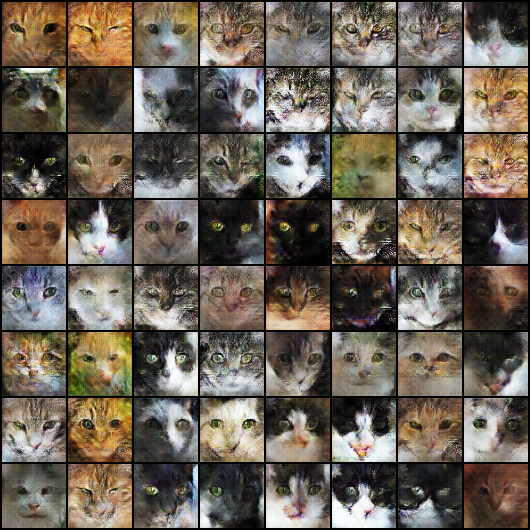

In [ ]:
Image('./generated/generated-images-0060.png')

In [ ]:
vid_fname = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

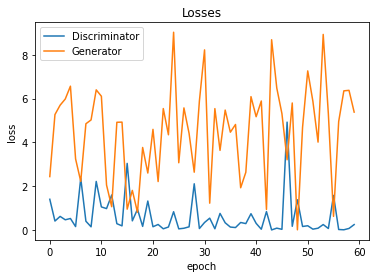

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

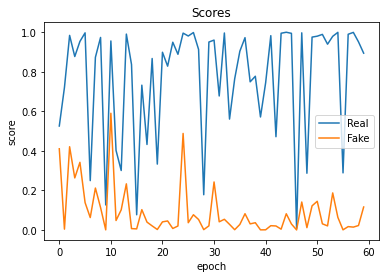

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# TO DO

## Improve GAN's behaviour.


1. Try to add more Conv-BN blocks in Discriminator
2. Try to add Pooling to Discriminator
3. Try to add more Conv-BN blocks in Generator
4. Increase `latent_size`
5. Try use ELU or LeakyReLU

For more tips on improving GAN's stability you can check this [source](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)


## Generate Fake Faces!


1. Add CenterCrop transformation to images and reduce their size
2. Use deeper GAN model
3. Obtain model that produce reasonably good faces ("resembling a car crash victim" or better)


In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz

--2021-04-14 08:23:38--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

tmp.tgz             100%[===================>] 103.72M  98.9MB/s    in 1.0s    

2021-04-14 08:23:39 (98.9 MB/s) - ‘tmp.tgz’ saved [108761145/108761145]



In [ ]:
!tar xvzf tmp.tgz && rm tmp.tgz

Streaming output truncated to the last 5000 lines.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0012.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0013.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunne

In [ ]:
DATA_DIR = './lfw-deepfunneled/'
image_size = 250
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose(#YOUR_CODE)